In [2]:
import pandas as pd
import numpy as np 
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
path = '/Users/aadithyaviswanathr/.cache/kagglehub/datasets/parasharmanas/movie-recommendation-system/versions/1'
movies = pd.read_csv(path + "/movies.csv")
ratings = pd.read_csv(path + "/ratings.csv")

In [4]:
class RecommenderModel(nn.Module):
    def __init__(self, num_users, num_movies, num_genres, embedding_dim=32):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)

        self.genre_fc = nn.Sequential(
            nn.Linear(num_genres, embedding_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.fc1 = nn.Linear(embedding_dim * 2  + embedding_dim // 2, 32)
        self.fc2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, userid, movieid, genres):
        user_embediing = self.user_embedding(userid)
        movie_embedding = self.movie_embedding(movieid)
        genres = self.genre_fc(genres)
        x = torch.cat([user_embediing, movie_embedding, genres], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x).squeeze()

In [5]:
class MovieRatings(Dataset):
    def __init__(self, user_ids, movie_ids, ratings, genre_features,):
        self.user_ids = torch.LongTensor(user_ids)
        self.movie_ids = torch.LongTensor(movie_ids)
        self.ratings = torch.FloatTensor(ratings)
        self.genre_features = torch.FloatTensor(genre_features)

    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, index):
        return (self.user_ids[index], self.movie_ids[index], self.ratings[index], 
                self.genre_features[index])

In [6]:
class MovieRecommendationSystem:
    def __init__(self, embedding_dim=32, learning_rate=0.02):
        self.embedding_dim = embedding_dim 
        self.learning_rate = learning_rate 
        self.model = None 
        self.user_encoder = LabelEncoder()
        self.movie_encoder = LabelEncoder()
        self.genre_encoder = MultiLabelBinarizer()
        self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

    
    def prepare_genres(self, movies_df):
        """Prepare genre features from the movies dataframe"""
        # Handle different genre formats
        if movies_df['genres'].dtype == 'object':
            # If genres are strings like "Action|Comedy|Drama"
            if movies_df['genres'].str.contains('|').any():
                genre_lists = movies_df['genres'].str.split('|').tolist()
            else:
                # If genres are single strings
                genre_lists = [[genre] for genre in movies_df['genres'].tolist()]
        else:
            # If genres are already lists
            genre_lists = movies_df['genres'].tolist()
        
        # Create one-hot encoding for genres
        genre_matrix = self.genre_encoder.fit_transform(genre_lists)
        
        # Create movie_id to genre mapping
        movie_genre_dict = {}
        for idx, movie_id in enumerate(movies_df['movieid']):
            movie_genre_dict[movie_id] = genre_matrix[idx]
        
        return movie_genre_dict, genre_matrix.shape[1]
    
    
    def prepare_data(self, ratings_df, movies_df):
        """Prepare and encode the data with genre features"""
        # Prepare genres first
        self.movie_genre_dict, self.num_genres = self.prepare_genres(movies_df)
        
        # Encode user and movie IDs
        ratings_df['user_encoded'] = self.user_encoder.fit_transform(ratings_df['userid'])
        ratings_df['movie_encoded'] = self.movie_encoder.fit_transform(ratings_df['movieid'])
        
        # Add genre features to ratings dataframe
        ratings_df['genre_features'] = ratings_df['movieid'].map(self.movie_genre_dict)
        
        # Store mappings
        self.user_to_encoded = dict(zip(ratings_df['userid'], ratings_df['user_encoded']))
        self.movie_to_encoded = dict(zip(ratings_df['movieid'], ratings_df['movie_encoded']))
        self.encoded_to_user = dict(zip(ratings_df['user_encoded'], ratings_df['userid']))
        self.encoded_to_movie = dict(zip(ratings_df['movie_encoded'], ratings_df['movieid']))
        
        # Store movies dataframe for recommendations
        self.movies_df = movies_df
        
        # Create user-item interaction matrix for filtering
        self.user_movie_matrix = defaultdict(set)
        for _, row in ratings_df.iterrows():
            self.user_movie_matrix[row['userid']].add(row['movieid'])
        
        self.num_users = len(self.user_encoder.classes_)
        self.num_movies = len(self.movie_encoder.classes_)
        
        print(f"Data prepared:")
        print(f"- Users: {self.num_users}")
        print(f"- Movies: {self.num_movies}")
        print(f"- Genres: {self.num_genres}")
        print(f"- Genre features: {list(self.genre_encoder.classes_)}")
        
        return ratings_df
    
    def create_model(self):
        """Create the neural network model with genre support"""
        self.model = RecommenderModel(
            num_users=self.num_users,
            num_movies=self.num_movies,
            num_genres=self.num_genres,
            embedding_dim=self.embedding_dim,

        ).to(self.device)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        
        print(f"Model created with {sum(p.numel() for p in self.model.parameters())} parameters")
    

    def train_model(self, ratings_df, epochs=10, batch_size=1024, validation_split=0.2):
        """Train the recommendation model with genre features"""
        # Prepare training data
        X_users = ratings_df['user_encoded'].values
        X_movies = ratings_df['movie_encoded'].values
        X_genres = np.stack(ratings_df['genre_features'].values)
        y = ratings_df['rating'].values
        
        # Split data
        indices = np.arange(len(X_users))
        train_idx, val_idx = train_test_split(indices, test_size=validation_split, random_state=42)
        
        # Create datasets
        train_dataset = MovieRatings(
            X_users[train_idx], X_movies[train_idx], y[train_idx], X_genres[train_idx]
        )
        val_dataset = MovieRatings(
            X_users[val_idx], X_movies[val_idx], y[val_idx], X_genres[val_idx]
        )
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Training loop
        train_losses = []
        val_losses = []
        
        for epoch in range(epochs):
            # Training
            self.model.train()
            train_loss = 0
            for user_ids, movie_ids, ratings, genre_features in train_loader:
                user_ids = user_ids.to(self.device)
                movie_ids = movie_ids.to(self.device)
                ratings = ratings.to(self.device)
                genre_features = genre_features.to(self.device)
                
                self.optimizer.zero_grad()
                predictions = self.model(user_ids, movie_ids, genre_features).squeeze()
                loss = self.criterion(predictions, ratings)
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item()
            
            # Validation
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for user_ids, movie_ids, ratings, genre_features in val_loader:
                    user_ids = user_ids.to(self.device)
                    movie_ids = movie_ids.to(self.device)
                    ratings = ratings.to(self.device)
                    genre_features = genre_features.to(self.device)
                    
                    predictions = self.model(user_ids, movie_ids, genre_features).squeeze()
                    loss = self.criterion(predictions, ratings)
                    val_loss += loss.item()
            
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        return train_losses, val_losses
    
    
    def predict_rating(self, user_id, movie_id):
        """Predict rating for a user-movie pair"""
        if user_id not in self.user_to_encoded or movie_id not in self.movie_to_encoded:
            return None
        
        user_encoded = self.user_to_encoded[user_id]
        movie_encoded = self.movie_to_encoded[movie_id]
        genre_features = self.movie_genre_dict[movie_id]
        
        self.model.eval()
        with torch.no_grad():
            user_tensor = torch.LongTensor([user_encoded]).to(self.device)
            movie_tensor = torch.LongTensor([movie_encoded]).to(self.device)
            genre_tensor = torch.FloatTensor([genre_features]).to(self.device)
            prediction = self.model(user_tensor, movie_tensor, genre_tensor).item()
        
        return prediction
    
    def recommend_movies(self, user_id, top_k=5):
        """Recommend top-k movies for a user"""
        if user_id not in self.user_to_encoded:
            return []
        
        # Get movies the user has already rated
        rated_movies = self.user_movie_matrix[user_id]
        
        # Get all movies
        all_movies = set(self.movies_df['movieid'].values)
        
        # Get unrated movies
        unrated_movies = all_movies - rated_movies
        
        # Predict ratings for unrated movies
        predictions = []
        for movie_id in unrated_movies:
            if movie_id in self.movie_to_encoded:
                predicted_rating = self.predict_rating(user_id, movie_id)
                if predicted_rating is not None:
                    predictions.append((movie_id, predicted_rating))
        
        # Sort by predicted rating and get top-k
        predictions.sort(key=lambda x: x[1], reverse=True)
        top_recommendations = predictions[:top_k]
        
        # Get movie details
        recommendations = []
        for movie_id, predicted_rating in top_recommendations:
            movie_info = self.movies_df[self.movies_df['movieid'] == movie_id].iloc[0]
            recommendations.append({
                'movieid': movie_id,
                'title': movie_info['title'],
                'genres': movie_info['genres'],
                'predicted_rating': predicted_rating
            })
        
        return recommendations
    
    def analyze_genre_preferences(self, user_id, top_k=5):
        """Analyze user's genre preferences based on their ratings"""
        if user_id not in self.user_to_encoded:
            return {}
        
        # Get user's rated movies
        rated_movies = self.user_movie_matrix[user_id]
        
        # Get ratings for this user
        user_ratings = self.ratings_df[self.ratings_df['userid'] == user_id]
        
        # Calculate average rating per genre
        genre_ratings = defaultdict(list)
        for _, row in user_ratings.iterrows():
            movie_id = row['movieid']
            rating = row['rating']
            genre_features = self.movie_genre_dict[movie_id]
            
            # Get genre names for this movie
            active_genres = [genre for i, genre in enumerate(self.genre_encoder.classes_) 
                           if genre_features[i] == 1]
            
            for genre in active_genres:
                genre_ratings[genre].append(rating)
        
        # Calculate average rating per genre
        genre_preferences = {}
        for genre, ratings in genre_ratings.items():
            genre_preferences[genre] = {
                'avg_rating': np.mean(ratings),
                'count': len(ratings)
            }
        
        # Sort by average rating
        sorted_preferences = sorted(genre_preferences.items(), 
                                  key=lambda x: x[1]['avg_rating'], 
                                  reverse=True)
        
        return dict(sorted_preferences[:top_k])
    
    def plot_training_history(self, train_losses, val_losses):
        """Plot training and validation losses"""
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training History (With Genre Features)')
        plt.legend()
        plt.grid(True)
        plt.show()

In [7]:
ratings_df = pd.DataFrame(ratings)
movies_df = pd.DataFrame(movies)

ratings_df.rename(columns={'userId': 'userid', 'movieId':'movieid'}, inplace=True)
movies_df.rename(columns={'movieId': 'movieid'}, inplace=True)
    
# Initialize enhanced recommendation system
recommender = MovieRecommendationSystem(
    embedding_dim=16,
    learning_rate=0.005
)

In [8]:
# Prepare data with genre features
ratings_df = recommender.prepare_data(ratings_df, movies_df)

# Create and train model
recommender.create_model()
print("Training model with genre features...")

Data prepared:
- Users: 162541
- Movies: 59047
- Genres: 20
- Genre features: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
Model created with 3547433 parameters
Training model with genre features...


In [9]:
train_losses, val_losses = recommender.train_model(
    ratings_df, 
    epochs=3, 
    batch_size=2048
)

Epoch 0/3, Train Loss: 0.8051, Val Loss: 0.7385


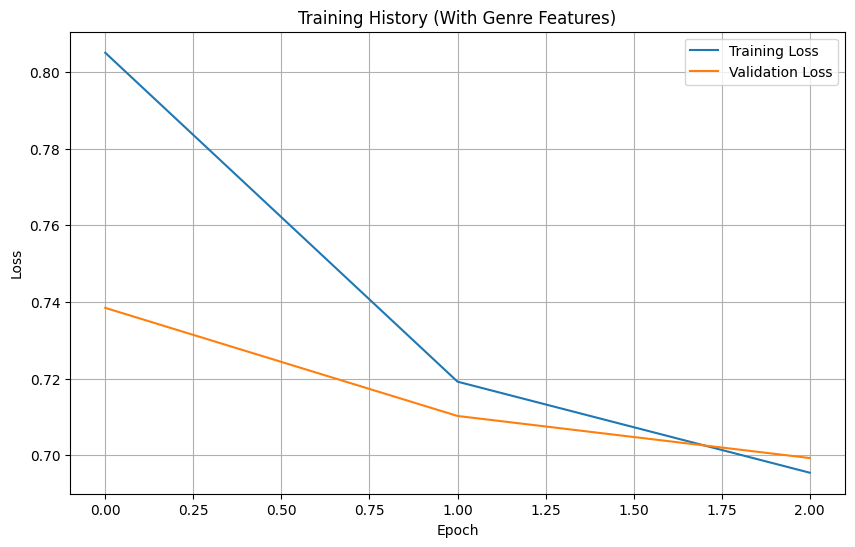

In [10]:
recommender.plot_training_history(train_losses, val_losses)

In [11]:
recommender.recommend_movies(user_id=11)

/var/folders/cd/myg_tw7916bgk0pc0r099msc0000gn/T/ipykernel_1402/667148813.py:174: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  genre_tensor = torch.FloatTensor([genre_features]).to(self.device)


[{'movieid': 171011,
  'title': 'Planet Earth II (2016)',
  'genres': 'Documentary',
  'predicted_rating': 4.192054271697998},
 {'movieid': 159817,
  'title': 'Planet Earth (2006)',
  'genres': 'Documentary',
  'predicted_rating': 4.183709144592285},
 {'movieid': 318,
  'title': 'Shawshank Redemption, The (1994)',
  'genres': 'Crime|Drama',
  'predicted_rating': 4.111088275909424},
 {'movieid': 159819,
  'title': 'Life (2009)',
  'genres': 'Documentary',
  'predicted_rating': 4.104037284851074},
 {'movieid': 170705,
  'title': 'Band of Brothers (2001)',
  'genres': 'Action|Drama|War',
  'predicted_rating': 4.082568645477295}]